# UNet

In [ ]:
# some basic imports

import math
import os
import re
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from random import sample
from PIL import Image

In [ ]:
PATH_PREFIX = "../"
PATCH_SIZE = 16  # pixels per side of square patches
CUTOFF = 0.25  # minimum average brightness for a mask patch to be classified as containing road
VAL_SIZE = 10  # size of the validation set (number of images)

## Load images

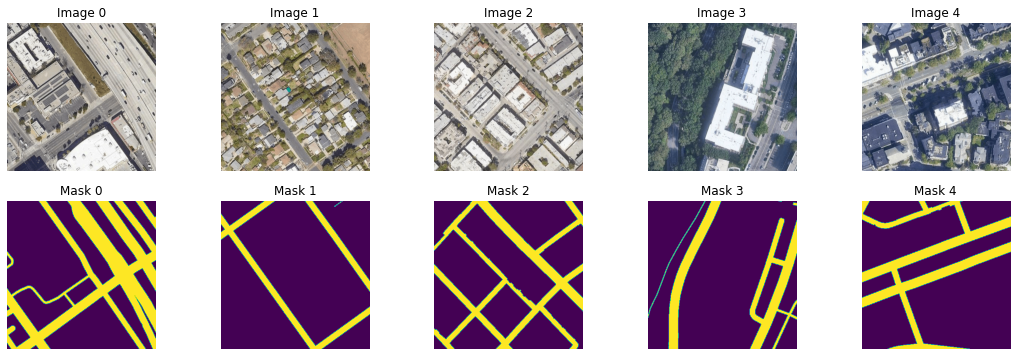

In [ ]:
def load_all_from_path(path):
    # loads all HxW .pngs contained in path as a 4D np.array of shape (n_images, H, W, 3)
    # images are loaded as floats with values in the interval [0., 1.]
    data = np.stack([np.array(Image.open(f)) for f in sorted(glob(path + '/*.png'))]).astype(np.float32) / 255.
    return data if len(data.shape) == 3 else np.delete(data, 3, axis=3) # delete the 4th channel (opacity) if present


def show_first_n(imgs, masks, n=5):
    # visualizes the first n elements of a series of images and segmentation masks
    imgs_to_draw = min(5, len(imgs))
    fig, axs = plt.subplots(2, imgs_to_draw, figsize=(18.5, 6))
    for i in range(imgs_to_draw):
        axs[0, i].imshow(imgs[i])
        axs[1, i].imshow(masks[i])
        axs[0, i].set_title(f'Image {i}')
        axs[1, i].set_title(f'Mask {i}')
        axs[0, i].set_axis_off()
        axs[1, i].set_axis_off()
    plt.show()
    

# paths to training and validation datasets
train_path = 'training'
val_path = 'validation'

all_images = load_all_from_path(os.path.join(PATH_PREFIX, train_path, 'images'))
all_masks = load_all_from_path(os.path.join(PATH_PREFIX, train_path, 'groundtruth'))
val_indices = np.random.choice(len(all_images), size=VAL_SIZE, replace=False)

train_images = np.delete(all_images, val_indices, axis=0)
train_masks = np.delete(all_masks, val_indices, axis=0)
val_images = all_images[val_indices]
val_masks = all_masks[val_indices]

# visualize a few images from the training set
show_first_n(train_images, train_masks)

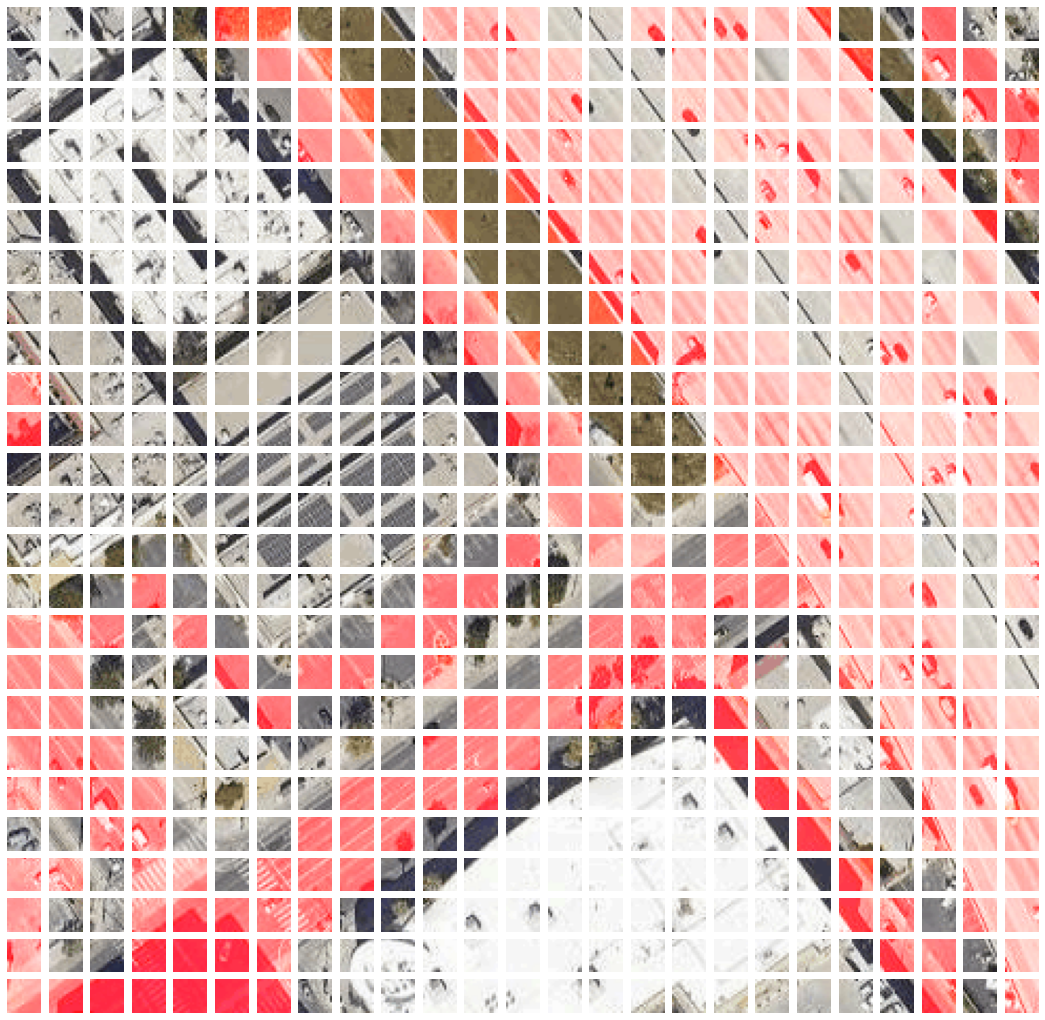

In [ ]:
def image_to_patches(images, masks=None):
    # takes in a 4D np.array containing images and (optionally) a 4D np.array containing the segmentation masks
    # returns a 4D np.array with an ordered sequence of patches extracted from the image and (optionally) a np.array containing labels
    n_images = images.shape[0]  # number of images
    h, w = images.shape[1:3]  # shape of images
    assert (h % PATCH_SIZE) + (w % PATCH_SIZE) == 0  # make sure images can be patched exactly

    h_patches = h // PATCH_SIZE
    w_patches = w // PATCH_SIZE
    patches = images.reshape((n_images, h_patches, PATCH_SIZE, h_patches, PATCH_SIZE, -1))
    patches = np.moveaxis(patches, 2, 3)
    patches = patches.reshape(-1, PATCH_SIZE, PATCH_SIZE, 3)
    if masks is None:
        return patches

    masks = masks.reshape((n_images, h_patches, PATCH_SIZE, h_patches, PATCH_SIZE, -1))
    masks = np.moveaxis(masks, 2, 3)
    labels = np.mean(masks, (-1, -2, -3)) > CUTOFF  # compute labels
    labels = labels.reshape(-1).astype(np.float32)
    return patches, labels


def show_patched_image(patches, labels, h_patches=25, w_patches=25):
    # reorders a set of patches in their original 2D shape and visualizes them
    fig, axs = plt.subplots(h_patches, w_patches, figsize=(18.5, 18.5))
    for i, (p, l) in enumerate(zip(patches, labels)):
        # the np.maximum operation paints patches labeled as road red
        axs[i // w_patches, i % w_patches].imshow(np.maximum(p, np.array([l.item(), 0., 0.])))
        axs[i // w_patches, i % w_patches].set_axis_off()
    plt.show()


# extract all patches and visualize those from the first image
train_patches, train_labels = image_to_patches(train_images, train_masks)
val_patches, val_labels = image_to_patches(val_images, val_masks)
# the first image is broken up in the first 25*25 patches
show_patched_image(train_patches[:25*25], train_labels[:25*25])

## Model

In [ ]:
import torch
from torch import nn
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import tqdm

In [ ]:
class Block(nn.Module):
    # a repeating structure composed of two convolutional layers with batch normalization and ReLU activations
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(nn.Conv2d(in_channels=in_ch, out_channels=out_ch, kernel_size=3, padding=1),
                                   nn.ReLU(),
                                   nn.BatchNorm2d(out_ch),
                                   nn.Conv2d(in_channels=out_ch, out_channels=out_ch, kernel_size=3, padding=1),
                                   nn.ReLU())

    def forward(self, x):
        return self.block(x)

        
class UNet(nn.Module):
    # UNet-like architecture for single class semantic segmentation.
    def __init__(self, chs=(3,64,128,256,512,1024)):
        super().__init__()
        enc_chs = chs  # number of channels in the encoder
        dec_chs = chs[::-1][:-1]  # number of channels in the decoder
        self.enc_blocks = nn.ModuleList([Block(in_ch, out_ch) for in_ch, out_ch in zip(enc_chs[:-1], enc_chs[1:])])  # encoder blocks
        self.pool = nn.MaxPool2d(2)  # pooling layer (can be reused as it will not be trained)
        self.upconvs = nn.ModuleList([nn.ConvTranspose2d(in_ch, out_ch, 2, 2) for in_ch, out_ch in zip(dec_chs[:-1], dec_chs[1:])])  # deconvolution
        self.dec_blocks = nn.ModuleList([Block(in_ch, out_ch) for in_ch, out_ch in zip(dec_chs[:-1], dec_chs[1:])])  # decoder blocks
        self.head = nn.Sequential(nn.Conv2d(dec_chs[-1], 1, 1), nn.Sigmoid()) # 1x1 convolution for producing the output

    def forward(self, x):
        # encode
        enc_features = []
        for block in self.enc_blocks[:-1]:
            x = block(x)  # pass through the block
            enc_features.append(x)  # save features for skip connections
            x = self.pool(x)  # decrease resolution
        x = self.enc_blocks[-1](x)
        # decode
        for block, upconv, feature in zip(self.dec_blocks, self.upconvs, enc_features[::-1]):
            x = upconv(x)  # increase resolution
            x = torch.cat([x, feature], dim=1)  # concatenate skip features
            x = block(x)  # pass through the block
        return self.head(x)  # reduce to 1 channel

def accuracy_fn(y_hat, y):
    # computes classification accuracy
    return (y_hat.round() == y.round()).float().mean()

def patch_accuracy_fn(y_hat, y):
    # computes accuracy weighted by patches (metric used on Kaggle for evaluation)
    h_patches = y.shape[-2] // PATCH_SIZE
    w_patches = y.shape[-1] // PATCH_SIZE
    patches_hat = y_hat.reshape(-1, 1, h_patches, PATCH_SIZE, w_patches, PATCH_SIZE).mean((-1, -3)) > CUTOFF
    patches = y.reshape(-1, 1, h_patches, PATCH_SIZE, w_patches, PATCH_SIZE).mean((-1, -3)) > CUTOFF
    return (patches == patches_hat).float().mean()

## Training loop

In [ ]:
def np_to_tensor(x, device):
    # allocates tensors from np.arrays
    if device == 'cpu':
        return torch.from_numpy(x).cpu()
    else:
        return torch.from_numpy(x).contiguous().pin_memory().to(device=device, non_blocking=True)


class ImageDataset(torch.utils.data.Dataset):
    # dataset class that deals with loading the data and making it available by index.

    def __init__(self, data, device, use_patches=False, resize_to=(400, 400)):
        self.data = data # (x, y)
        self.device = device
        self.use_patches = use_patches
        self.resize_to=resize_to
        self.x, self.y, self.n_samples = None, None, None
        self._load_data()

    def _load_data(self):  # not very scalable, but good enough for now
        self.x, self.y = self.data
        if self.use_patches:  # split each image into patches
            self.x, self.y = image_to_patches(self.x, self.y)
        elif self.resize_to != (self.x.shape[1], self.x.shape[2]):  # resize images
            self.x = np.stack([cv2.resize(img, dsize=self.resize_to) for img in self.x], 0)
            self.y = np.stack([cv2.resize(mask, dsize=self.resize_to) for mask in self.y], 0)
        self.x = np.moveaxis(self.x, -1, 1)  # pytorch works with CHW format instead of HWC
        self.n_samples = len(self.x)

    def _preprocess(self, x, y):
        # to keep things simple we will not apply transformations to each sample,
        # but it would be a very good idea to look into preprocessing
        return x, y

    def __getitem__(self, item):
        return self._preprocess(np_to_tensor(self.x[item], self.device), np_to_tensor(self.y[[item]], self.device))
    
    def __len__(self):
        return self.n_samples

def show_val_samples(x, y, y_hat, segmentation=False):
    # training callback to show predictions on validation set
    imgs_to_draw = min(5, len(x))
    if x.shape[-2:] == y.shape[-2:]:  # segmentation
        fig, axs = plt.subplots(3, imgs_to_draw, figsize=(18.5, 12))
        for i in range(imgs_to_draw):
            axs[0, i].imshow(np.moveaxis(x[i], 0, -1))
            axs[1, i].imshow(np.concatenate([np.moveaxis(y_hat[i], 0, -1)] * 3, -1))
            axs[2, i].imshow(np.concatenate([np.moveaxis(y[i], 0, -1)]*3, -1))
            axs[0, i].set_title(f'Sample {i}')
            axs[1, i].set_title(f'Predicted {i}')
            axs[2, i].set_title(f'True {i}')
            axs[0, i].set_axis_off()
            axs[1, i].set_axis_off()
            axs[2, i].set_axis_off()
    else:  # classification
        fig, axs = plt.subplots(1, imgs_to_draw, figsize=(18.5, 6))
        for i in range(imgs_to_draw):
            axs[i].imshow(np.moveaxis(x[i], 0, -1))
            axs[i].set_title(f'True: {np.round(y[i]).item()}; Predicted: {np.round(y_hat[i]).item()}')
            axs[i].set_axis_off()
    plt.show()

In [ ]:
def train(train_dataloader, eval_dataloader, model, loss_fn, metric_fns, optimizer, n_epochs):
    # training loop
    logdir = os.path.join(PATH_PREFIX, './tensorboard/net')
    writer = SummaryWriter(logdir)  # tensorboard writer (can also log images)

    history = {}  # collects metrics at the end of each epoch

    for epoch in range(n_epochs):  # loop over the dataset multiple times

        # initialize metric list
        metrics = {'loss': [], 'val_loss': []}
        for k, _ in metric_fns.items():
            metrics[k] = []
            metrics['val_'+k] = []

        pbar = tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{n_epochs}')
        # training
        model.train()
        for (x, y) in pbar:
            optimizer.zero_grad()  # zero out gradients
            y_hat = model(x)  # forward pass
            loss = loss_fn(y_hat, y)
            loss.backward()  # backward pass
            optimizer.step()  # optimize weights

            # log partial metrics
            metrics['loss'].append(loss.item())
            for k, fn in metric_fns.items():
                metrics[k].append(fn(y_hat, y).item())
            pbar.set_postfix({k: sum(v)/len(v) for k, v in metrics.items() if len(v) > 0})

        # validation
        model.eval()
        with torch.no_grad():  # do not keep track of gradients
            for (x, y) in eval_dataloader:
                y_hat = model(x)  # forward pass
                loss = loss_fn(y_hat, y)
                
                # log partial metrics
                metrics['val_loss'].append(loss.item())
                for k, fn in metric_fns.items():
                    metrics['val_'+k].append(fn(y_hat, y).item())

        # summarize metrics, log to tensorboard and display
        history[epoch] = {k: sum(v) / len(v) for k, v in metrics.items()}
        for k, v in history[epoch].items():
          writer.add_scalar(k, v, epoch)
        print(' '.join(['\t- '+str(k)+' = '+str(v)+'\n ' for (k, v) in history[epoch].items()]))
        show_val_samples(x.detach().cpu().numpy(), y.detach().cpu().numpy(), y_hat.detach().cpu().numpy())

    print('Finished Training')
    # plot loss curves
    plt.plot([v['loss'] for k, v in history.items()], label='Training Loss')
    plt.plot([v['val_loss'] for k, v in history.items()], label='Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

## Train

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# reshape the image to simplify the handling of skip connections and maxpooling
train_dataset = ImageDataset((train_images, train_masks), device, use_patches=False, resize_to=(384, 384))
val_dataset = ImageDataset((val_images, val_masks), device, use_patches=False, resize_to=(384, 384))
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=True)
model = UNet().to(device)
loss_fn = nn.BCELoss()
metric_fns = {'acc': accuracy_fn, 'patch_acc': patch_accuracy_fn}
optimizer = torch.optim.Adam(model.parameters())
n_epochs = 35
train(train_dataloader, val_dataloader, model, loss_fn, metric_fns, optimizer, n_epochs)

# predict on test set
test_filenames = (glob(test_path + '/*.png'))
test_images = load_all_from_path(test_path)
batch_size = test_images.shape[0]
size = test_images.shape[1:3]
# we also need to resize the test images. This might not be the best ideas depending on their spatial resolution.
test_images = np.stack([cv2.resize(img, dsize=(384, 384)) for img in test_images], 0)
test_images = np_to_tensor(np.moveaxis(test_images, -1, 1), device)
test_pred = [model(t).detach().cpu().numpy() for t in test_images.unsqueeze(1)]
test_pred = np.concatenate(test_pred, 0)
test_pred= np.moveaxis(test_pred, 1, -1)  # CHW to HWC
test_pred = np.stack([cv2.resize(img, dsize=size) for img in test_pred], 0)  # resize to original shape
# now compute labels
test_pred = test_pred.reshape((-1, size[0] // PATCH_SIZE, PATCH_SIZE, size[0] // PATCH_SIZE, PATCH_SIZE))
test_pred = np.moveaxis(test_pred, 2, 3)
test_pred = np.round(np.mean(test_pred, (-1, -2)) > CUTOFF)
create_submission(test_pred, test_filenames, submission_filename='unet_submission.csv')

Epoch 1/35:   0%|          | 0/17 [00:00<?, ?it/s]

KernelInterrupted: Execution interrupted by the Jupyter kernel.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ddedec99-c003-49f8-9064-90484ffbe195' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>